# CNN-MNIST

## setup

In [1]:
import time

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision import datasets
from torchvision.transforms import ToTensor

## explore data

In [2]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
batch_size = 128

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28])
Shape of y: torch.Size([128]) torch.int64


In [4]:
def data_summary():
    print(f"{training_data=}")
    print("\n")
    print(f"{test_data=}")


data_summary()

training_data=Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


test_data=Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


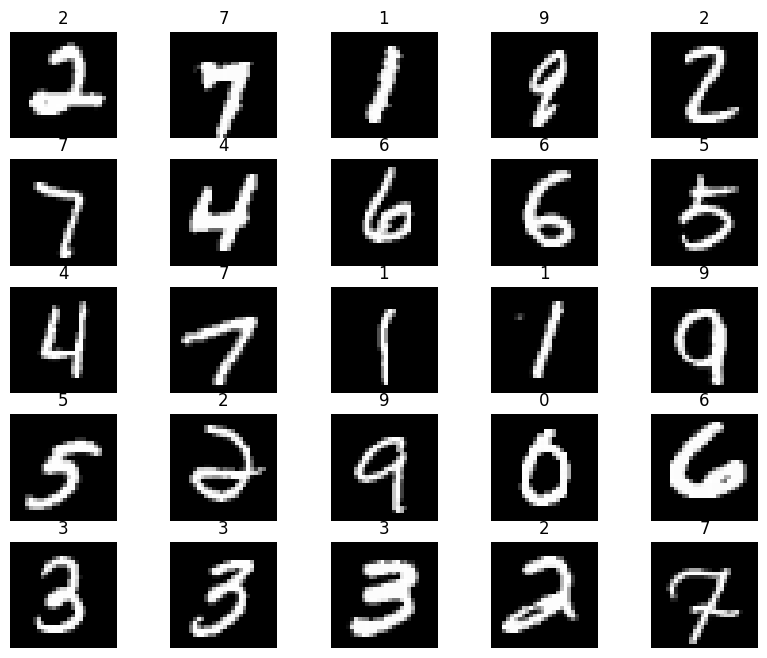

In [5]:
def viz_data():
    figure = plt.figure(figsize=(10, 8))
    cols, rows = 5, 5
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(training_data), size=(1,)).item()
        img, label = training_data[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()


viz_data()

## create models

In [6]:
def get_device():
    if not torch.backends.mps.is_available():
        if not torch.backends.mps.is_built():
            print(
                "MPS not available because the current PyTorch install was not "
                "built with MPS enabled."
            )
        else:
            print(
                "MPS not available because the current MacOS version is not 12.3+ "
                "and/or you do not have an MPS-enabled device on this machine."
            )
        return "cpu"
    return "mps"

In [7]:
# Get cpu or gpu device for training.
device = get_device()
print(f"Using {device=}")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_relu_stack = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=3,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
            ),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(9216, 128),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
            nn.LogSoftmax(),
        )

    def forward(self, x):
        logits = self.cnn_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)
summary(model)

Using device='mps'


Layer (type:depth-idx)                   Param #
NeuralNetwork                            --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       320
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       18,496
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Dropout: 2-6                      --
│    └─Flatten: 2-7                      --
│    └─Linear: 2-8                       1,179,776
│    └─Dropout: 2-9                      --
│    └─Linear: 2-10                      1,290
│    └─LogSoftmax: 2-11                  --
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0

## train models

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [10]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )

In [11]:
epochs = 12
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    start_time = time.monotonic()
    train(train_dataloader, model, loss_fn, optimizer)
    end_time = time.monotonic()
    total_time = end_time - start_time
    print(f"time: {total_time:.2f}s")
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.298841  [    0/60000]


/opt/homebrew/Caskroom/miniconda/base/envs/ml-playground/lib/python3.9/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss: 0.163229  [12800/60000]
loss: 0.116437  [25600/60000]
loss: 0.118382  [38400/60000]
loss: 0.141809  [51200/60000]
time: 5.06s
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.069753 

Epoch 2
-------------------------------
loss: 0.119537  [    0/60000]
loss: 0.058128  [12800/60000]
loss: 0.060773  [25600/60000]
loss: 0.111181  [38400/60000]
loss: 0.147900  [51200/60000]
time: 4.64s
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.042923 

Epoch 3
-------------------------------
loss: 0.048566  [    0/60000]
loss: 0.032529  [12800/60000]
loss: 0.035483  [25600/60000]
loss: 0.075453  [38400/60000]
loss: 0.072820  [51200/60000]
time: 4.72s
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.040242 

Epoch 4
-------------------------------
loss: 0.042110  [    0/60000]
loss: 0.042601  [12800/60000]
loss: 0.058946  [25600/60000]
loss: 0.101954  [38400/60000]
loss: 0.044360  [51200/60000]
time: 4.69s
Test Error: 
 Accuracy: 98.7%, Avg loss: 0.039280 

Epoch 5
-------------------------------
loss: 0.048556